# Foldseek results

In [4]:
import os
import re
import subprocess

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Entrez

In [5]:
headers = ['query', 'target', 'identity', 'alignment_length', 'mismatches', 'gap_opens', 'q_start', 'q_end', 't_start', 't_end',
           'q_alignment', 't_alignment', 'evalue', 'bit_score', 'probability', 'lddt', 'alignment_tm_score']

In [6]:
foldseek_results = pd.read_csv('../foldseek/foldseek_esmfold_cmv_rl11_with_rl11d_only_results.tsv', sep='\t', names=headers)

In [7]:
foldseek_results

,query,target,identity,alignment_length,mismatches,gap_opens,q_start,q_end,t_start,t_end,q_alignment,t_alignment,evalue,bit_score,probability,lddt,alignment_tm_score
0,papiinebeta4_RL11R.pdb,papiinebeta4_RL11R.pdb,1.000,211,0,0,1,211,1,211,MWIRMFNGHLFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTAT...,MWIRMFNGHLFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTAT...,6.111000e-42,1602,1.000,1.0000,1.0000
1,papiinebeta4_RL11R.pdb,mandrillinebeta1_RL11R.pdb,0.542,221,85,3,1,209,1,217,MWIRMFNGHLFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTAT...,MWIHMFQWYIFPYSILKHVQCTLQCKNTSIINAIAHENVTLNGTAA...,4.146000e-25,612,1.000,0.7581,0.5263
2,papiinebeta4_RL11R.pdb,cercopithecinebeta5_RL11R.pdb,0.492,207,99,4,1,205,1,203,MWIRMFNGH-LFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTA...,MWHRMVKCHIILLYLFKGHAPNTLRCKHTWLINATVNTNVTLNGTM...,1.392000e-22,529,1.000,0.7673,0.4789
3,papiinebeta4_RL11R.pdb,macacinebetajap_RL11R.pdb,0.373,209,121,8,2,207,4,205,WIRMFNGHLFLYFI--NGYTQQTLQCKNTSTINVTAHENVTIHGTA...,YIRRYLGEWNITMLLVQTCVQSTEPCTNTYSINVTANDNVVLNATR...,4.339000e-18,432,1.000,0.7184,0.5235
4,papiinebeta4_RL11R.pdb,macacinebeta3_RL11R.pdb,0.367,204,124,3,4,207,8,206,RMFNGHLFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTATLYD...,YLIQWIIAISLVHTRIQIAHPCKITSLINVTAYETVVLNATLALDK...,7.529000e-18,418,1.000,0.7146,0.5064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18018,macacinebeta3_RL11Q.pdb,mandrillinebeta1_RL11T.pdb,0.174,189,125,11,20,200,179,344,TLECTITKVVTTQSGANVRLGDSSRQ---GN-IVW-HRPPC-GNEQ...,PILAYTLVLVNATEGDTVNLTAINVTSDSHHHTYWVLLDNSTGKPK...,2.612000e-06,148,1.000,0.6801,0.4404
18019,macacinebeta3_RL11Q.pdb,humanadeno3_CR1beta.pdb,0.149,208,127,10,3,200,2,169,LTWTRLILLSNQLQMIWTLECTITKVVTTQSGANVRLGDSSRQGNI...,ASVTALIIAS----IVTVAHGQTIVHIT--LGHNHTLVGPPITSEV...,3.702000e-07,147,1.000,0.6030,0.3928
18020,macacinebeta3_RL11Q.pdb,macacinebeta8_RL11T.pdb,0.170,194,118,10,20,196,164,331,TLECTITKVVTTQSGANVRLGDSSRQ----GNIVWHRPPCGNEQ--...,AVLGYTLIKVNATVGETVNLTATNFSLTTHHHTYWVLMHNKTGKPT...,2.941000e-06,145,1.000,0.6821,0.4285
18021,macacinebeta3_RL11Q.pdb,macacinebetajap_RL11T.pdb,0.202,193,112,14,20,196,169,335,TLECTITKVVTTQSGANVRLGDS--SRQ-GN-IVWHRPPCGNEQ--...,VLG-YTLVKVNATVGETVNLTATNFSITTHSHTYWVLM-YNKSKVM...,3.332000e-05,122,1.000,0.6676,0.4345


# Make a df with a summary statistis for each target

What target is the best?
- number of queries aligned to it
- alignment length

In [5]:
query_dict = {'target':[],
              'gene_name':[],
              'organism':[],
              'number_of_queries':[],
              'average_identity':[],
              'average_alignment_length':[],
              'average_bit_score':[],
              'average_lddt':[],
              'average_alignment_tm_score':[]}

for i, row in foldseek_results.iterrows():

    target = row['target']

    if target not in query_dict['target']:

        query_dict['target'].append(target)
        df = foldseek_results[foldseek_results['target'] == target]

        gene_name = target.split('_')[1]
        query_dict['gene_name'].append(gene_name)
        organism = target.split('_')[0]
        query_dict['organism'].append(organism)

        df_len = len(df)
        query_dict['number_of_queries'].append(df_len)

        query_dict['average_identity'].append(df['identity'].mean())
        query_dict['average_alignment_length'].append(df['alignment_length'].mean())
        query_dict['average_bit_score'].append(df['bit_score'].mean())
        query_dict['average_lddt'].append(df['lddt'].mean())
        query_dict['average_alignment_tm_score'].append(df['alignment_tm_score'].mean())

target_df = pd.DataFrame(query_dict)

In [6]:
target_df

,target,gene_name,organism,number_of_queries,average_identity,average_alignment_length,average_bit_score,average_lddt,average_alignment_tm_score
0,papiinebeta4_RL11R.pdb,RL11R.pdb,papiinebeta4,134,0.182455,200.537313,232.798507,0.620366,0.470192
1,mandrillinebeta1_RL11R.pdb,RL11R.pdb,mandrillinebeta1,134,0.187582,210.619403,232.358209,0.625199,0.455513
2,cercopithecinebeta5_RL11R.pdb,RL11R.pdb,cercopithecinebeta5,134,0.191507,204.320896,229.313433,0.632128,0.474352
3,macacinebetajap_RL11R.pdb,RL11R.pdb,macacinebetajap,134,0.184545,199.298507,233.791045,0.653348,0.482307
4,macacinebeta3_RL11R.pdb,RL11R.pdb,macacinebeta3,134,0.178642,197.723881,221.126866,0.637649,0.482665
...,...,...,...,...,...,...,...,...,...
130,papiinebeta4_RL11B3.pdb,RL11B3.pdb,papiinebeta4,134,0.181851,196.455224,205.791045,0.623084,0.470428
131,mandrillinebeta1_RL11B3.pdb,RL11B3.pdb,mandrillinebeta1,134,0.177993,179.261194,169.544776,0.564154,0.489940
132,cercopithecinebeta5_RL11P.pdb,RL11P.pdb,cercopithecinebeta5,135,0.168119,250.185185,164.985185,0.592053,0.391076
133,humanadeno17_CR1beta.pdb,CR1beta.pdb,humanadeno17,134,0.179254,211.477612,159.753731,0.574112,0.365294


In [7]:
query_list = target_df['target'].tolist()

## Targets with the highest number of queries aligned to them

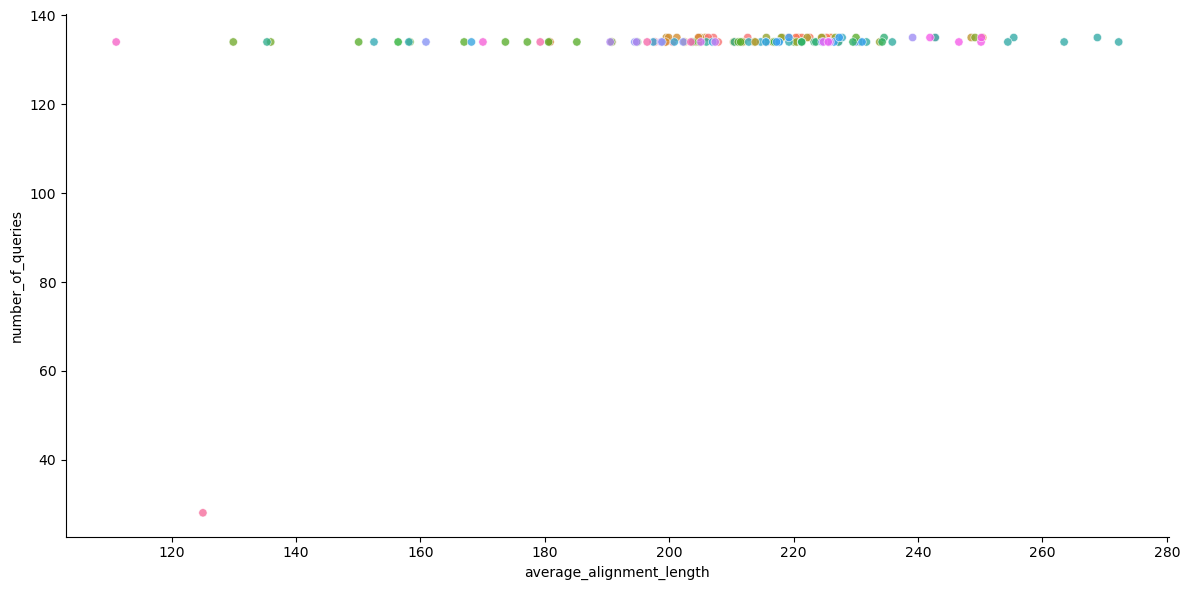

In [8]:
sns.relplot(data=target_df, x='average_alignment_length', y='number_of_queries', hue='gene_name', alpha=.8, height=6, aspect=2, legend=False)

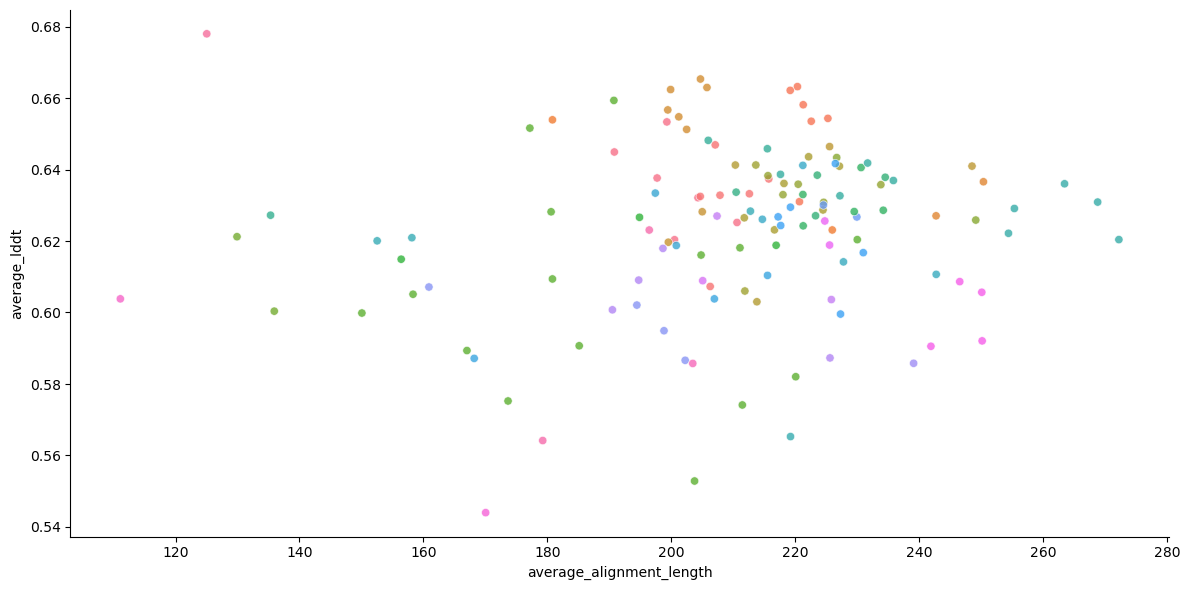

In [9]:
sns.relplot(data=target_df, x='average_alignment_length', y='average_lddt', hue='gene_name', alpha=.8, height=6, aspect=2, legend=False)

## Try mandrillinebeta1_RL11J because it has the highest average LDDT

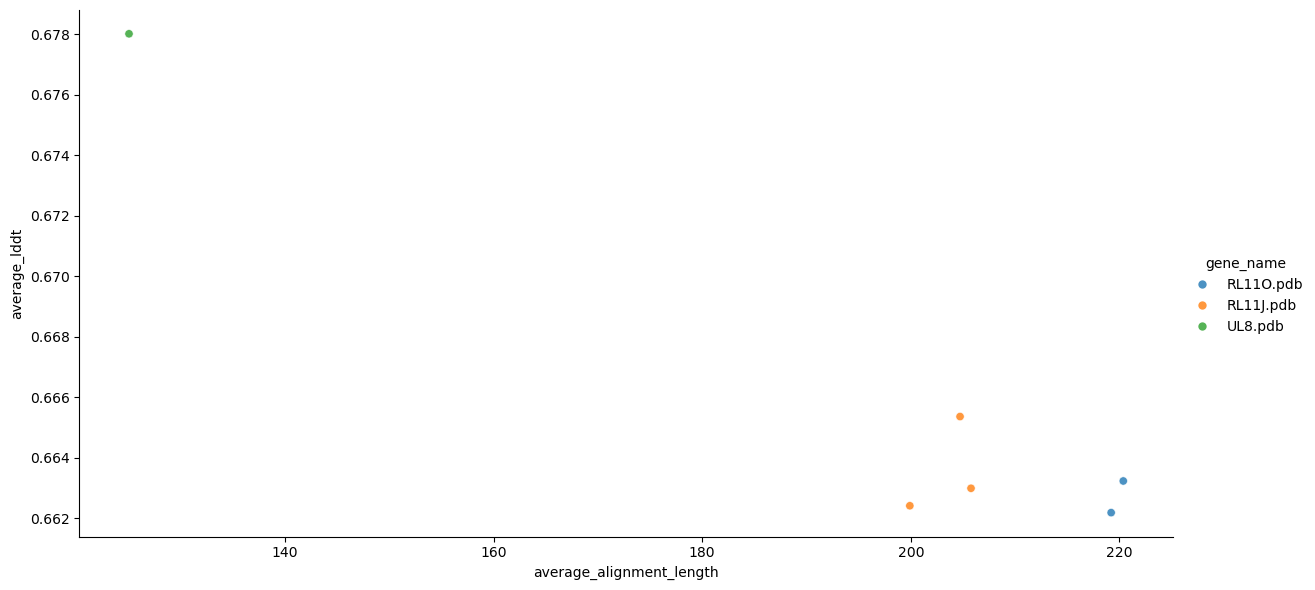

In [10]:
sns.relplot(data=target_df[(target_df['average_lddt'] > 0.66) & (target_df['average_lddt'] < 0.95)], x='average_alignment_length', y='average_lddt', hue='gene_name', alpha=.8, height=6, aspect=2, legend=True)

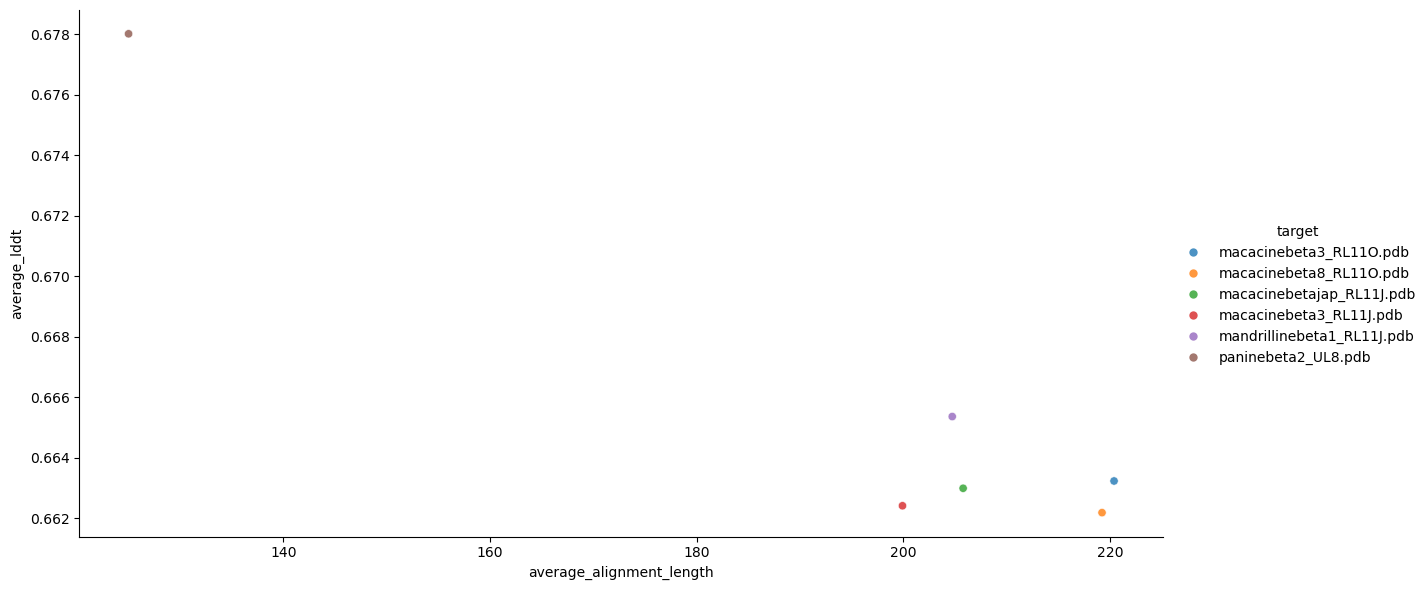

In [12]:
sns.relplot(data=target_df[(target_df['average_lddt'] > 0.66) & (target_df['average_lddt'] < 0.96)], x='average_alignment_length', y='average_lddt', hue='target', alpha=.8, height=6, aspect=2, legend=True)

## One target

In [16]:
ref_id = 'mandrillinebeta1_RL11J'
pdb_id = ref_id + '.pdb'

In [17]:
one_target_df = foldseek_results[foldseek_results['target'] == pdb_id ]

In [18]:
one_target_df

,query,target,identity,alignment_length,mismatches,gap_opens,q_start,q_end,t_start,t_end,q_alignment,t_alignment,evalue,bit_score,probability,lddt,alignment_tm_score
65,papiinebeta4_RL11R.pdb,mandrillinebeta1_RL11J.pdb,0.175,217,151,11,1,202,1,204,MWIRMFNGHLFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTAT...,MSIWMLS-----ILITQYSHSVYLP-TCTLKTCCAGDEIVLESHIP...,8.581000e-10,212,1.0,0.6618,0.4422
167,mandrillinebeta1_RL11F.pdb,mandrillinebeta1_RL11J.pdb,0.120,183,139,8,15,196,13,174,TLASHIIETIHNISVTLYRPVNLIDTYNHDRFHWYEWTTNATSWKC...,YSHSVYLPTCTLKTCCAGDEIVLESHIPST-CHMVTWYRH----KN...,1.539000e-09,228,1.0,0.6533,0.5100
299,cercopithecinebeta5_RL11C1.pdb,mandrillinebeta1_RL11J.pdb,0.179,195,131,11,12,195,3,179,LWLYTICIFKTAHYIK-ASSYTLYAHVGGNVTFVDLTDTKIVHTG-...,IWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHI-PSTCHMVT...,1.093000e-09,223,1.0,0.5728,0.4989
437,macacinebetajap_RL11I.pdb,mandrillinebeta1_RL11J.pdb,0.174,224,150,10,93,310,3,197,VEIQDRISALWTNGCY---CGSLSVLPGANVTLNSTKKQTNTETMW...,IWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPSTCHMVTW...,8.757000e-11,211,1.0,0.5345,0.4363
586,mandrillinebeta1_RL11T.pdb,mandrillinebeta1_RL11J.pdb,0.153,189,118,7,176,343,13,180,TAAPILAYTLVLVNATEGDTVNLTAINVTSDSHHHTYWVLLDNSTG...,YSHSVYLPTCTLKTCCAGDEIVLES-HIPS-TCHMVTWYRHKNN--...,1.216000e-08,195,1.0,0.5963,0.5090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17362,humanbeta5_UL7.pdb,mandrillinebeta1_RL11J.pdb,0.172,203,156,5,20,220,2,194,HYVYNKLLILTLFAPVILESVIYVSGPQGGNVTLVSNFTSNI-SAR...,SIWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPSTCHMVT...,2.298000e-13,334,1.0,0.7393,0.5227
17526,papiinebeta4_RL11B2.pdb,mandrillinebeta1_RL11J.pdb,0.138,216,149,7,9,219,4,187,FTSTIILLLCKTGYSDTSFTNIYAHVGDNVTLPDVQCQYNNCFKGE...,WMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHI--PSTCHMVT...,4.129000e-09,213,1.0,0.6675,0.4673
17652,macacinebeta3_RL11C.pdb,mandrillinebeta1_RL11J.pdb,0.142,204,134,8,7,188,2,186,VLYSITFLFREMCYT--KHIIYNYSTVAGGTVTFFDVTGYSGFTKG...,SIWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHI-PSTCHMV...,1.771000e-09,236,1.0,0.6666,0.5207
17786,mandrillinebeta1_RL11B2.pdb,mandrillinebeta1_RL11J.pdb,0.136,212,148,10,9,217,3,182,LYSIYTSIVLCTTGYTETSFINIYTHVDNNVTLQDVKCQKITCLKA...,IWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPST--CHMV...,2.789000e-10,242,1.0,0.6654,0.4733


In [19]:
target_list = one_target_df['query'].tolist()

In [20]:
for query in query_list:

    if query not in target_list:

        print(query)

## Plot target coverage

In [21]:
one_target_df_cov_dict = {'query':[],
                          't_position':[]}

for i, row in one_target_df.iterrows():

    query = row['query']

    t_start = row['t_start']
    t_end = row['t_end']

    for i in range(t_start,t_end+1):
        one_target_df_cov_dict['query'].append(query)
        one_target_df_cov_dict['t_position'].append(i)

one_target_cov_df = pd.DataFrame(one_target_df_cov_dict)

In [22]:
one_target_cov_df

,query,t_position
0,papiinebeta4_RL11R.pdb,1
1,papiinebeta4_RL11R.pdb,2
2,papiinebeta4_RL11R.pdb,3
3,papiinebeta4_RL11R.pdb,4
4,papiinebeta4_RL11R.pdb,5
...,...,...
24502,macacinebeta3_RL11Q.pdb,185
24503,macacinebeta3_RL11Q.pdb,186
24504,macacinebeta3_RL11Q.pdb,187
24505,macacinebeta3_RL11Q.pdb,188


<Axes: xlabel='t_position', ylabel='Count'>

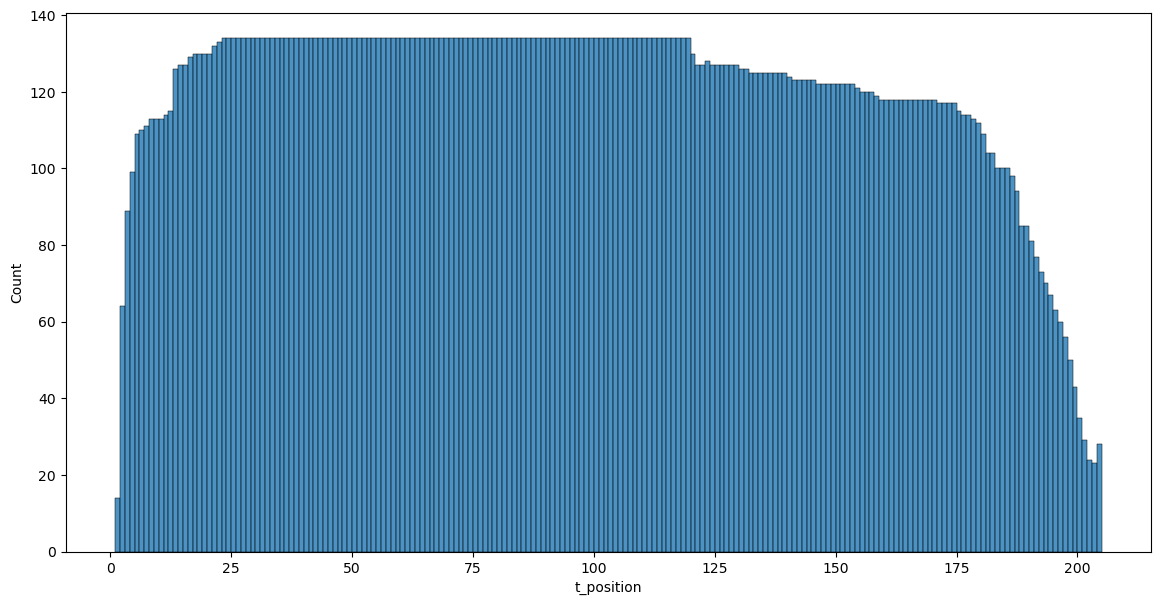

In [23]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.histplot(data=one_target_cov_df, x='t_position', binwidth=1, kde=False, alpha=.8, ax=ax)

## Show queries with low probability, lddt, and tm score

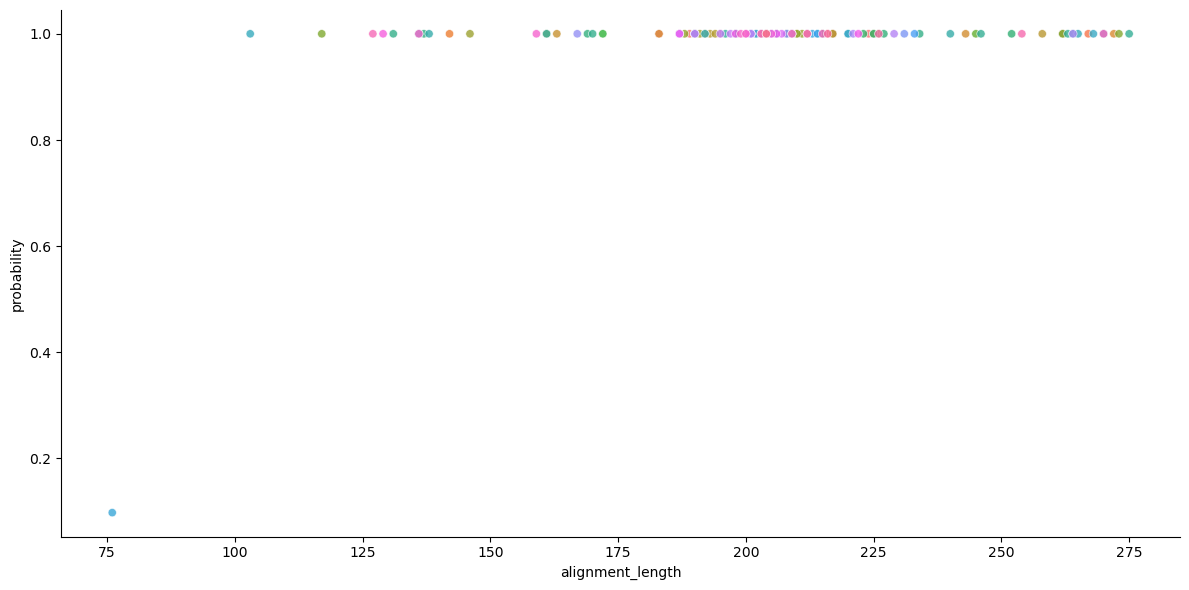

In [24]:
sns.relplot(data=one_target_df, x='alignment_length', y='probability', hue='query',
            alpha=.8, height=6, aspect=2, legend=False)

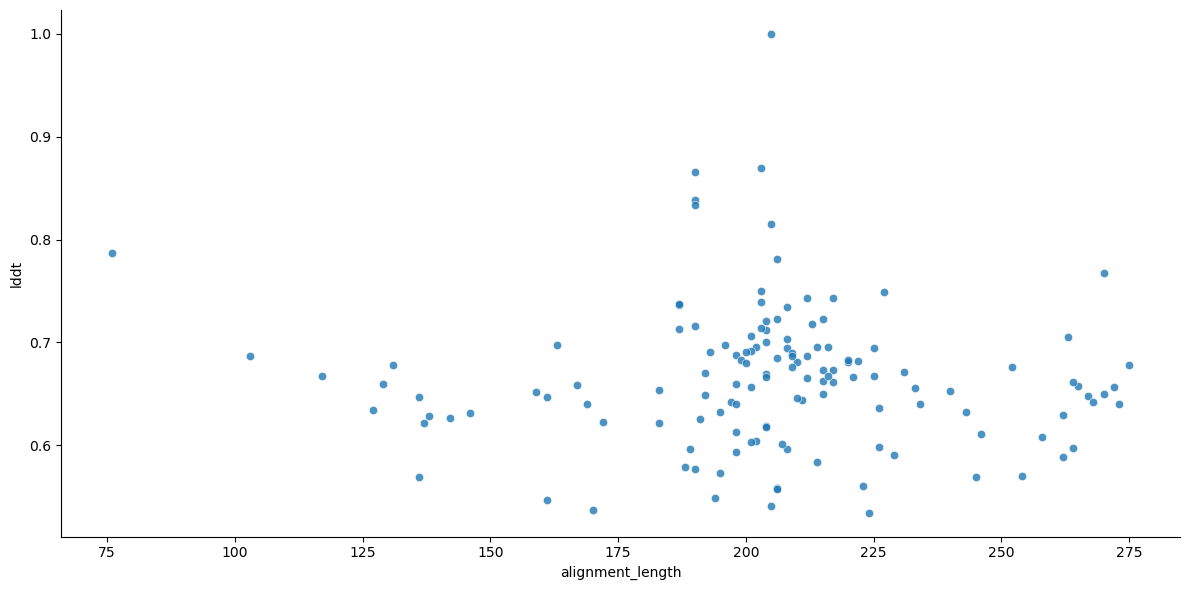

In [25]:
sns.relplot(data=one_target_df, x='alignment_length', y='lddt', alpha=.8, height=6, aspect=2)

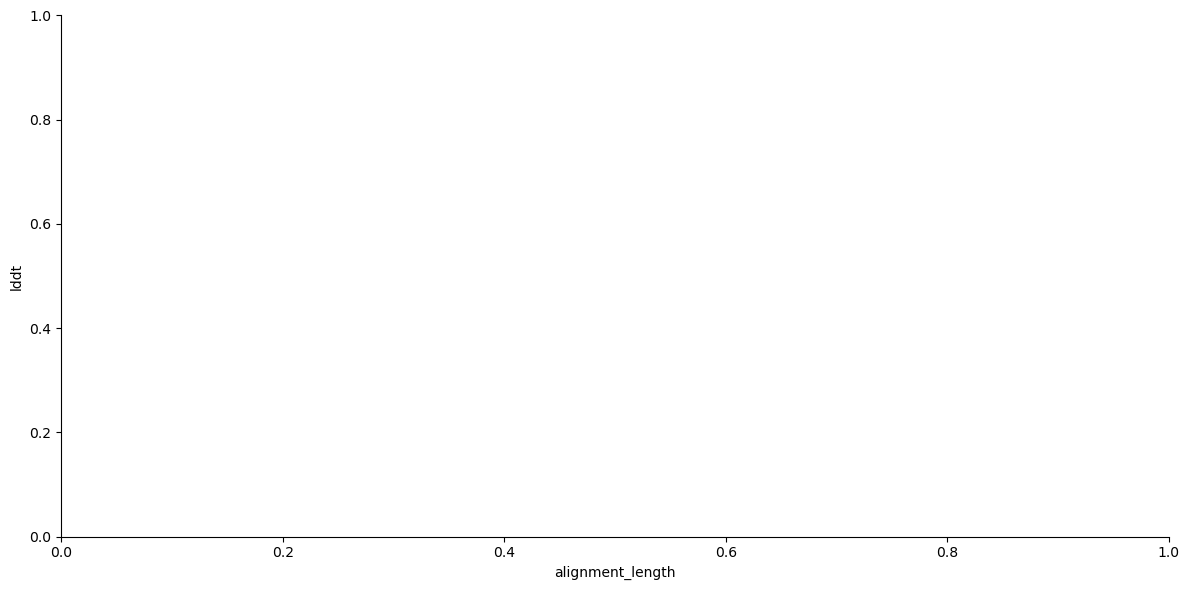

In [26]:
sns.relplot(data=one_target_df[one_target_df['lddt'] < 0.5],
            x='alignment_length', y='lddt', hue='query',
            alpha=.8, height=6, aspect=2, legend=True)

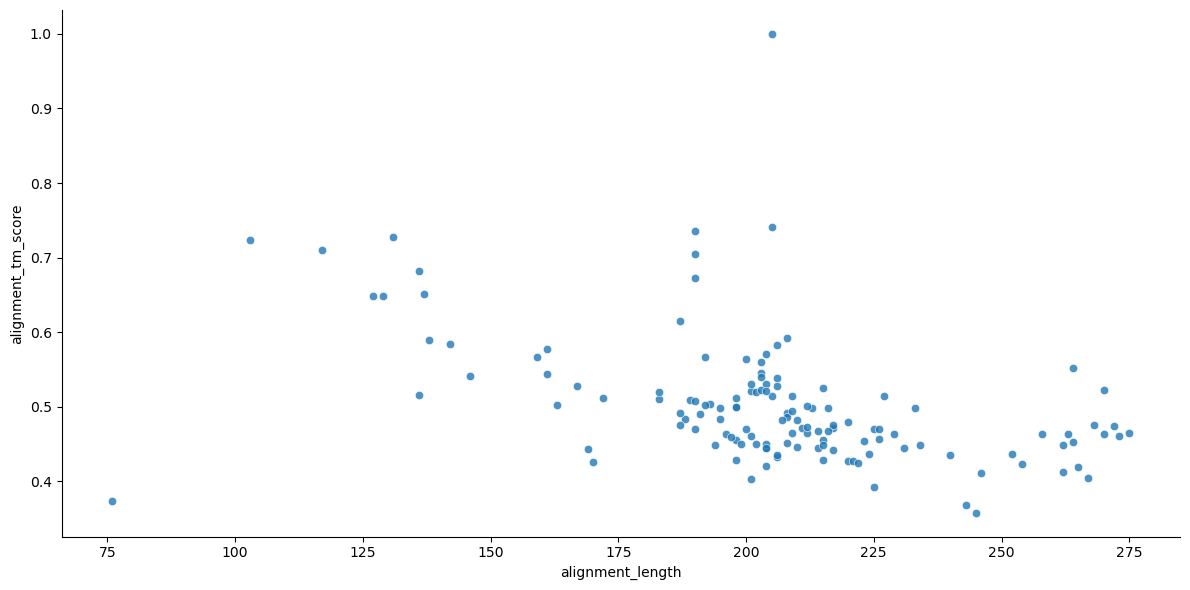

In [27]:
sns.relplot(data=one_target_df, x='alignment_length', y='alignment_tm_score', alpha=.8, height=6, aspect=2)

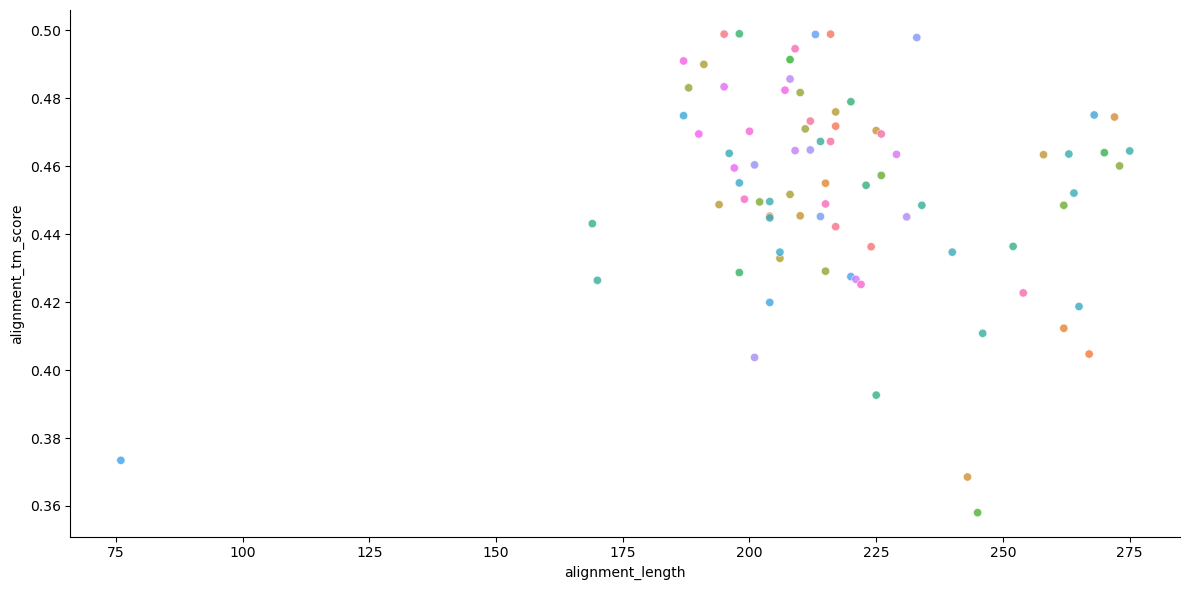

In [28]:
sns.relplot(data=one_target_df[one_target_df['alignment_tm_score'] < 0.5],
            x='alignment_length', y='alignment_tm_score', hue='query',
            alpha=.8, height=6, aspect=2, legend=False)

In [29]:
one_target_df

,query,target,identity,alignment_length,mismatches,gap_opens,q_start,q_end,t_start,t_end,q_alignment,t_alignment,evalue,bit_score,probability,lddt,alignment_tm_score
65,papiinebeta4_RL11R.pdb,mandrillinebeta1_RL11J.pdb,0.175,217,151,11,1,202,1,204,MWIRMFNGHLFLYFINGYTQQTLQCKNTSTINVTAHENVTIHGTAT...,MSIWMLS-----ILITQYSHSVYLP-TCTLKTCCAGDEIVLESHIP...,8.581000e-10,212,1.0,0.6618,0.4422
167,mandrillinebeta1_RL11F.pdb,mandrillinebeta1_RL11J.pdb,0.120,183,139,8,15,196,13,174,TLASHIIETIHNISVTLYRPVNLIDTYNHDRFHWYEWTTNATSWKC...,YSHSVYLPTCTLKTCCAGDEIVLESHIPST-CHMVTWYRH----KN...,1.539000e-09,228,1.0,0.6533,0.5100
299,cercopithecinebeta5_RL11C1.pdb,mandrillinebeta1_RL11J.pdb,0.179,195,131,11,12,195,3,179,LWLYTICIFKTAHYIK-ASSYTLYAHVGGNVTFVDLTDTKIVHTG-...,IWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHI-PSTCHMVT...,1.093000e-09,223,1.0,0.5728,0.4989
437,macacinebetajap_RL11I.pdb,mandrillinebeta1_RL11J.pdb,0.174,224,150,10,93,310,3,197,VEIQDRISALWTNGCY---CGSLSVLPGANVTLNSTKKQTNTETMW...,IWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPSTCHMVTW...,8.757000e-11,211,1.0,0.5345,0.4363
586,mandrillinebeta1_RL11T.pdb,mandrillinebeta1_RL11J.pdb,0.153,189,118,7,176,343,13,180,TAAPILAYTLVLVNATEGDTVNLTAINVTSDSHHHTYWVLLDNSTG...,YSHSVYLPTCTLKTCCAGDEIVLES-HIPS-TCHMVTWYRHKNN--...,1.216000e-08,195,1.0,0.5963,0.5090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17362,humanbeta5_UL7.pdb,mandrillinebeta1_RL11J.pdb,0.172,203,156,5,20,220,2,194,HYVYNKLLILTLFAPVILESVIYVSGPQGGNVTLVSNFTSNI-SAR...,SIWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPSTCHMVT...,2.298000e-13,334,1.0,0.7393,0.5227
17526,papiinebeta4_RL11B2.pdb,mandrillinebeta1_RL11J.pdb,0.138,216,149,7,9,219,4,187,FTSTIILLLCKTGYSDTSFTNIYAHVGDNVTLPDVQCQYNNCFKGE...,WMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHI--PSTCHMVT...,4.129000e-09,213,1.0,0.6675,0.4673
17652,macacinebeta3_RL11C.pdb,mandrillinebeta1_RL11J.pdb,0.142,204,134,8,7,188,2,186,VLYSITFLFREMCYT--KHIIYNYSTVAGGTVTFFDVTGYSGFTKG...,SIWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHI-PSTCHMV...,1.771000e-09,236,1.0,0.6666,0.5207
17786,mandrillinebeta1_RL11B2.pdb,mandrillinebeta1_RL11J.pdb,0.136,212,148,10,9,217,3,182,LYSIYTSIVLCTTGYTETSFINIYTHVDNNVTLQDVKCQKITCLKA...,IWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPST--CHMV...,2.789000e-10,242,1.0,0.6654,0.4733


## Extract MSA

In [33]:
align_file = '../foldseek/al_foldseek_esmfold_' + ref_id + '.fa'
fasta_file = '../fasta_files/adeno_cr1_cmv_rl11_elephantidbeta_ee50.fa'

for seq_record in SeqIO.parse(fasta_file, "fasta"):
    if seq_record.id == ref_id:
        print(seq_record.id)
        ref_seq = str(seq_record.seq)
        print(ref_seq)

mandrillinebeta1_RL11J
MSIWMLSILITQYSHSVYLPTCTLKTCCAGDEIVLESHIPSTCHMVTWYRHKNNSERLLCRFSGGSVTLNLGERIPSTCSAQSFIFHNIKQPSTGTYYSVGNSCDSHPIMSTCYNVTVHSRFTTQRSLASTQQGAKSTPMMASIIQEHNDNNTYIDRTLNVHGTWGLVIVALLMLWIANEFRLFQRMFRYCNARFRASTRLIQTV


In [34]:
if os.path.isfile(align_file):
    os.remove(align_file)

for inded, row in one_target_df[one_target_df['probability'] >= 0.9].iterrows():

    query_align_seq = '-' * len(ref_seq)
    #target_align_seq = '-' * len(ref_seq)

    query_id = row['query'].rstrip('.pdb')

    query_seq = row['q_alignment']
    target_seq = row['t_alignment']

    target_match_index = re.search(target_seq.replace('-', ''), ref_seq)
    target_seq_not_a_gap_index_list = [i for i, c in enumerate(target_seq) if c != "-"]

    #target_match = ''.join([target_seq[x] for x in target_seq_not_a_gap_index_list])

    query_match = ''.join([query_seq[x] for x in target_seq_not_a_gap_index_list])

    #target_align_seq = target_align_seq[:target_match_index.start()] + target_match + target_align_seq[target_match_index.end():]

    query_align_seq = query_align_seq[:target_match_index.start()] + query_match + query_align_seq[target_match_index.end():]
    
    with open(align_file, 'a') as f:
        f.write('>' + query_id + '\n')
        f.write(query_align_seq + '\n')